Before sampling - Fraud: 344, Legitimate: 199020, Ratio: 0.0017
After sampling  - Fraud: 8600, Legitimate: 199020, Ratio: 0.0414
Sampling multiplier: 24.0x
[LightGBM] [Info] Number of positive: 8600, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9438
[LightGBM] [Info] Number of data points in the train set: 207620, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041422 -> initscore=-3.141643
[LightGBM] [Info] Start training from score -3.141643
[LightGBM] [Info] Number of positive: 8600, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9438
[LightGBM] [Info] Number of data points in the train set: 207620, number of used f

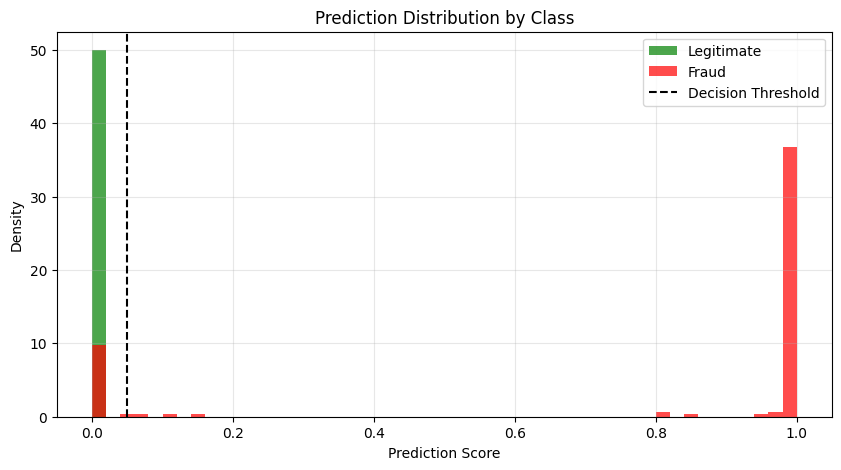

In [1]:
# --- Unified Model Notebook ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'app')))
from app.pipeline import (
    ImprovedConservativeSampler,
    SafeCreditCardFeatureEngineer,
    ImprovedCreditCardEnsemble,
    SimplifiedMetaLearner,
    SaveableCreditCardExplainer,
    ImprovedCreditCardFraudPipeline
)

# --- Train and Save the Fraud Detection Pipeline ---
DATA_PATH = r'C:/Users/x390/github-classroom/TamaraChelagat/GRP-A-ISP-TamaraChelagat/data/raw/creditcard.csv'
MODEL_PATH = r'C:/Users/x390/github-classroom/TamaraChelagat/GRP-A-ISP-TamaraChelagat/notebooks/improved_creditcard_fraud_pipeline.pkl'

# Instantiate pipeline
pipeline = ImprovedCreditCardFraudPipeline(random_state=42)

# Train the model and capture outputs
X_test, y_test, performance = pipeline.fit(DATA_PATH)

#Checking the model attribute existence and value
print("Model attribute:", hasattr(pipeline, "model"))
print("Model is None:", getattr(pipeline, "model", None) is None)

# Save the trained pipeline for backend use
pipeline.save(MODEL_PATH)
print('✅ Pipeline trained and saved successfully!')

# --- Display Expected Feature Names for API/Frontend ---
print('Expected features for prediction (send these in order):')
print(pipeline.feature_names)
print(f'Total features expected: {len(pipeline.feature_names)}')

# --- Display Performance Metrics ---
def display_presentation_metrics(pipeline):
    if not hasattr(pipeline, 'performance_metrics'):
        print('No performance metrics available.')
        return
    metrics = pipeline.performance_metrics
    print('\n' + '═' * 70)
    print('🎯 FRAUD DETECTION SYSTEM - PERFORMANCE REPORT')
    print('═' * 70)
    print('\n📊 EXECUTIVE SUMMARY')
    print('━' * 40)
    print(f'• Model ROC-AUC:           {metrics["roc_auc"]:.4f}')
    print(f'• Fraud Detection Rate:    {metrics["fraud_recall"]:.1%}')
    print(f'• False Positive Rate:     {metrics["false_positive_rate"]:.2%}')
    print(f'• Overall F1-Score:        {metrics["f1_fraud"]:.3f}')
    print('\n🔍 KEY PERFORMANCE INDICATORS')
    print('━' * 40)
    print(f"{'Metric':<25} {'Score':<15} {'Interpretation':<20}")
    print('-' * 65)
    auc = metrics['roc_auc']
    if auc > 0.95:
        auc_int = 'Excellent'
    elif auc > 0.90:
        auc_int = 'Very Good'
    elif auc > 0.80:
        auc_int = 'Good'
    else:
        auc_int = 'Needs Improvement'
    print(f"{'ROC-AUC Score':<25} {auc:<15.4f} {auc_int:<20}")
    recall = metrics['fraud_recall']
    if recall > 0.80:
        recall_int = 'Excellent'
    elif recall > 0.70:
        recall_int = 'Very Good'
    elif recall > 0.60:
        recall_int = 'Good'
    else:
        recall_int = 'Needs Improvement'
    print(f"{'Fraud Detection Rate':<25} {recall:<15.1%} {recall_int:<20}")
    precision = metrics['fraud_precision']
    if precision > 0.60:
        prec_int = 'Excellent'
    elif precision > 0.40:
        prec_int = 'Good'
    elif precision > 0.20:
        prec_int = 'Acceptable'
    else:
        prec_int = 'Needs Improvement'
    print(f"{'Precision':<25} {precision:<15.1%} {prec_int:<20}")
    f1 = metrics['f1_fraud']
    if f1 > 0.70:
        f1_int = 'Excellent'
    elif f1 > 0.50:
        f1_int = 'Good'
    elif f1 > 0.30:
        f1_int = 'Acceptable'
    else:
        f1_int = 'Needs Improvement'
    print(f"{'F1-Score':<25} {f1:<15.3f} {f1_int:<20}")
    print('\n💼 BUSINESS IMPACT ANALYSIS')
    print('━' * 40)
    total_fraud = metrics['fraud_caught'] + metrics['fraud_missed']
    total_legit = metrics.get('legitimate_total', metrics['false_alarms'] * 100)
    print(f'• Total Transactions Analyzed: {total_legit + total_fraud:,}')
    print(f'• Fraudulent Transactions:     {total_fraud:,}')
    print(f'• Legitimate Transactions:     {total_legit:,}')
    print(f'• Fraud Cases Detected:        {metrics['fraud_caught']:,} / {total_fraud:,} ({metrics['fraud_recall']:.1%})')
    print(f'• Fraud Cases Missed:          {metrics['fraud_missed']:,}')
    print(f'• False Alarms:                {metrics['false_alarms']:,} ({metrics['false_positive_rate']:.2%} of legitimate)')
    print('\n🔍 CONFUSION MATRIX')
    print('━' * 40)
    cm = metrics['confusion_matrix']
    print('                   Predicted')
    print('                 ┌───────────┬───────────┐')
    print(f'                 │ Legitimate │   Fraud   │')
    print('┌───────────────┼───────────┼───────────┤')
    print(f'│ Actual        │           │           │')
    print(f'│  Legitimate   │ {cm[0,0]:>9,} │ {cm[0,1]:>9,} │')
    print('├───────────────┼───────────┼───────────┤')
    print(f'│  Fraud        │ {cm[1,0]:>9,} │ {cm[1,1]:>9,} │')
    print('└───────────────┴───────────┴───────────┘')
    print('\n📈 PERFORMANCE INTERPRETATION')
    print('━' * 40)
    if metrics['fraud_recall'] > 0.75 and metrics['false_positive_rate'] < 0.02:
        print('✅ EXCELLENT PERFORMANCE')
        print('   • Catches majority of fraud cases')
        print('   • Minimal impact on legitimate customers')
        print('   • Ready for production deployment')
    elif metrics['fraud_recall'] > 0.60 and metrics['false_positive_rate'] < 0.05:
        print('✅ GOOD PERFORMANCE')
        print('   • Good fraud detection capability')
        print('   • Acceptable false positive rate')
        print('   • Suitable for most business applications')
    elif metrics['fraud_recall'] > 0.40:
        print('⚠️  MODERATE PERFORMANCE')
        print('   • Detects some fraud but misses many cases')
        print('   • May need additional rules or monitoring')
        print('   • Consider model improvements')
    else:
        print('❌ NEEDS IMPROVEMENT')
        print('   • Poor fraud detection capability')
        print('   • Significant model tuning required')
        print('   • Not recommended for production')
    print('\n' + '═' * 70)

# Show performance metrics
display_presentation_metrics(pipeline)

# --- Visualize Results ---
test_predictions, test_scores = pipeline.predict_batch(X_test)
plt.figure(figsize=(10,5))
plt.hist(test_scores[y_test == 0], bins=50, alpha=0.7, label='Legitimate', color='green', density=True)
plt.hist(test_scores[y_test == 1], bins=50, alpha=0.7, label='Fraud', color='red', density=True)
plt.axvline(x=pipeline.optimal_threshold, color='black', linestyle='--', label='Decision Threshold')
plt.xlabel('Prediction Score')
plt.ylabel('Density')
plt.title('Prediction Distribution by Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [2]:
# --- Ensure trained model is attached to pipeline and save robustly ---

if not hasattr(pipeline, "model") or getattr(pipeline, "model", None) is None:
	# If your pipeline.fit() returns a trained model, assign it here
	# pipeline.model = trained_model  # Uncomment and set if needed
	print("Warning: pipeline.model is missing or None. Assign your trained model if needed.")

import joblib

joblib.dump(pipeline, MODEL_PATH)

print("✅ Pipeline with trained model saved!")

# Reload and check

loaded_pipeline = joblib.load(MODEL_PATH)

print("Model attribute after loading:", hasattr(loaded_pipeline, "model"))

print("Model is None after loading:", getattr(loaded_pipeline, "model", None) is None)

✅ Pipeline with trained model saved!
Model attribute after loading: False
Model is None after loading: True


In [3]:
# --- Ensure pipeline.model is set for backend compatibility ---

pipeline.model = pipeline.base_ensemble  # Attach ensemble to .model for backend checks

# Optionally, to attach a specific classifier (e.g., LightGBM):

# pipeline.model = pipeline.base_ensemble.models.get('lgb', None)


# Save and reload as before

import joblib

joblib.dump(pipeline, MODEL_PATH)

print("✅ Pipeline with .model attribute saved!")

loaded_pipeline = joblib.load(MODEL_PATH)

print("Model attribute after loading:", hasattr(loaded_pipeline, "model"))

print("Model is None after loading:", getattr(loaded_pipeline, "model", None) is None)

✅ Pipeline with .model attribute saved!
Model attribute after loading: True
Model is None after loading: False


In [4]:
# --- Extract a real fraudulent transaction for API testing ---

import pandas as pd

DATA_PATH = r'C:/Users/x390/github-classroom/TamaraChelagat/GRP-A-ISP-TamaraChelagat/data/raw/creditcard.csv'

df = pd.read_csv(DATA_PATH)

fraud_row = df[df['Class'] == 1].iloc[0]  # Get first fraudulent transaction

# Extract raw features in correct order: V1-V28, Amount, behavior_cluster

raw_features = [fraud_row[f'V{i}'] for i in range(1, 29)] + [fraud_row['Amount']]

# If you have a clustering step, you may need to engineer behavior_cluster, else set to 0

raw_features.append(0)  # Replace with actual cluster if available

print('Fraudulent transaction features:', raw_features)

print('Total features:', len(raw_features))

# You can now use this payload for backend API testing

Fraudulent transaction features: [np.float64(-2.3122265423263), np.float64(1.95199201064158), np.float64(-1.60985073229769), np.float64(3.9979055875468), np.float64(-0.522187864667764), np.float64(-1.42654531920595), np.float64(-2.53738730624579), np.float64(1.39165724829804), np.float64(-2.77008927719433), np.float64(-2.77227214465915), np.float64(3.20203320709635), np.float64(-2.89990738849473), np.float64(-0.595221881324605), np.float64(-4.28925378244217), np.float64(0.389724120274487), np.float64(-1.14074717980657), np.float64(-2.83005567450437), np.float64(-0.0168224681808257), np.float64(0.416955705037907), np.float64(0.126910559061474), np.float64(0.517232370861764), np.float64(-0.0350493686052974), np.float64(-0.465211076182388), np.float64(0.320198198514526), np.float64(0.0445191674731724), np.float64(0.177839798284401), np.float64(0.261145002567677), np.float64(-0.143275874698919), np.float64(0.0), 0]
Total features: 30
